In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import copy

In [2]:
# Define image loader function
def image_loader(image_path, max_size=400, shape=None):
    image = Image.open(image_path)
    
    # Resize image if necessary
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Add batch dimension
    image = transform(image)[:3, :, :].unsqueeze(0)
    return image.to(device, torch.float)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.843908..2.4831376].


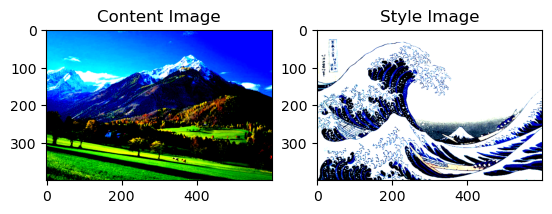

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load images
content_image = image_loader("original.png")
style_image = image_loader("style_image.png", shape=[content_image.size(2), content_image.size(3)])

# Display images
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Content Image")
plt.imshow(content_image.cpu().squeeze(0).permute(1, 2, 0))

plt.subplot(1, 2, 2)
plt.title("Style Image")
plt.imshow(style_image.cpu().squeeze(0).permute(1, 2, 0))
plt.show()

In [5]:
# Use a pretrained VGG model
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# Specify layers for content and style
content_layers = ["conv_4"]
style_layers = ["conv_1", "conv_2", "conv_3", "conv_4", "conv_5"]

C:\Users\ahmed\anaconda3\envs\neuralnetwork\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ahmed\anaconda3\envs\neuralnetwork\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\ahmed/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:14<00:00, 40.5MB/s] 


In [6]:
# Define helper classes for loss
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
    
    def forward(self, x):
        self.loss = nn.functional.mse_loss(x, self.target)
        return x

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = self.gram_matrix(target_feature).detach()

    def gram_matrix(self, x):
        a, b, c, d = x.size()
        features = x.view(a * b, c * d)
        G = torch.mm(features, features.t())
        return G.div(a * b * c * d)
    
    def forward(self, x):
        G = self.gram_matrix(x)
        self.loss = nn.functional.mse_loss(G, self.target)
        return x

In [7]:
# Function to get the model for style transfer
def get_style_model_and_losses(cnn, style_image, content_image):
    cnn = copy.deepcopy(cnn)
    
    content_losses = []
    style_losses = []
    
    model = nn.Sequential()
    i = 0
    
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = "conv_{}".format(i)
        elif isinstance(layer, nn.ReLU):
            name = "relu_{}".format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = "pool_{}".format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = "bn_{}".format(i)
        
        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_image).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_image).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
    
    # Trim off the layers after the last content and style loss layers
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    
    model = model[:i + 1]
    
    return model, style_losses, content_losses

In [8]:
input_image = content_image.clone()

# Style transfer parameters
optimizer = optim.LBFGS([input_image.requires_grad_()])
model, style_losses, content_losses = get_style_model_and_losses(cnn, style_image, content_image)

num_steps = 300
style_weight = 1000000
content_weight = 1

for step in range(num_steps):
    def closure():
        input_image.data.clamp_(0, 1)
        optimizer.zero_grad()
        model(input_image)
        
        style_score = sum([sl.loss for sl in style_losses]) * style_weight
        content_score = sum([cl.loss for cl in content_losses]) * content_weight

        loss = style_score + content_score
        loss.backward()

        if step % 50 == 0:
            print(f"Step {step}: Style Loss: {style_score.item():.4f} Content Loss: {content_score.item():.4f}")
        
        return style_score + content_score
    
    optimizer.step(closure)

# Clamp to valid image range
input_image.data.clamp_(0, 1)

Step 0: Style Loss: 40816.8438 Content Loss: 8.8467
Step 0: Style Loss: 40816.3828 Content Loss: 8.8467
Step 0: Style Loss: 40544.2695 Content Loss: 8.8516
Step 0: Style Loss: 28377.6152 Content Loss: 13.8064
Step 0: Style Loss: 21460.8320 Content Loss: 19.8881
Step 0: Style Loss: 16913.9043 Content Loss: 21.9389
Step 0: Style Loss: 13207.8115 Content Loss: 23.2441
Step 0: Style Loss: 11416.2158 Content Loss: 25.2775
Step 0: Style Loss: 10752.1084 Content Loss: 27.4222
Step 0: Style Loss: 9869.3203 Content Loss: 29.0239
Step 0: Style Loss: 8880.0010 Content Loss: 29.9238
Step 0: Style Loss: 8264.7412 Content Loss: 30.8656
Step 0: Style Loss: 8451.6143 Content Loss: 31.7398
Step 0: Style Loss: 8639.9561 Content Loss: 32.3979
Step 0: Style Loss: 8339.7256 Content Loss: 32.4390
Step 0: Style Loss: 10062.6738 Content Loss: 33.2337
Step 0: Style Loss: 16762.4316 Content Loss: 33.1411
Step 0: Style Loss: 54068.5039 Content Loss: 41.7337
Step 0: Style Loss: 29273.6992 Content Loss: 35.5494
St

KeyboardInterrupt: 

In [ ]:
# Display the resulting image
plt.figure()
plt.imshow(input_image.cpu().squeeze(0).permute(1, 2, 0))
plt.title("Output Image")
plt.show()